# MNIST IF v. TRAK 

In [43]:
import gc


In [37]:
import math
import random
from typing import List, Optional, Any, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from random import shuffle
from torch import nn
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.utils import data
from tueplots import cycler, markers
from tueplots.constants import markers as marker_constants
from tueplots.constants.color import palettes
from tqdm import tqdm


from pipeline import construct_model, get_loaders, get_hyperparameters

plt.rcParams.update({"figure.dpi": 150})
plt.rcParams.update(markers.with_edge())

# Model and Data Setup 

In [ ]:
dataset_name = "mnist"
dataset_dir = "./data"

# change 
train_batch_size = 32
eval_batch_size = 128
num_train_epochs = 40
learning_rate = 0.03
weight_decay = 0.001

In [9]:
train_loader, eval_train_loader, valid_loader = get_loaders(data_name="mnist", eval_batch_size=1024)

#train_dataset = get_mnist_dataloader(data_name=dataset_name, split="train", dataset_dir=dataset_dir)
#query_dataset = get_mnist_dataloader(data_name=dataset_name, split="valid", dataset_dir=dataset_dir)
#train_dataset.data_x.shape, train_dataset.data_y.shape

Using downloaded and verified file: /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw

Using downloaded and verified file: /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw

Using downloaded and verified file: /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8236285.68it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



In [119]:
model = construct_model()

In [24]:
import os
import time
import numpy as np

### utils

In [22]:
def set_seed(seed: int) -> None:
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [33]:
def save_tensor(tensor: Any, file_name: str, overwrite: bool = False) -> bool:
    if not os.path.exists(file_name):
        torch.save(tensor, file_name)
        return False
    else:
        if overwrite:
            print(f"Removing existing file at {file_name}.")
            torch.save(tensor, file_name)
        else:
            print("Found existing file. Skipping.")
        return True

In [41]:
def clear_gpu_cache() -> None:
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

## Main Train Loop 

In [16]:
def main(
    data_name: str = "mnist", 
    num_train: int = 5, 
    do_corrupt: bool = False,
) -> None:
    os.makedirs("./files", exist_ok=True)
    os.makedirs("./files/checkpoints", exist_ok=True)

    train_loader, _, valid_loader = get_loaders(
        data_name=data_name,
        do_corrupt=do_corrupt,
    )
    hyper_dict = get_hyperparameters(data_name)
    lr = hyper_dict["lr"]
    wd = hyper_dict["wd"]

    save_name = f"data_{data_name}"
    if do_corrupt:
        save_name += "_corrupted"

    for i in range(num_train):
        print(f"Training {i}th model.")
        start_time = time.time()

        last_epoch_name = f"../files/checkpoints/data_{data_name}/model_{i}/epoch_20.pt"
        if os.path.exists(last_epoch_name):
            print("Already exists!")
        else:
            set_seed(i)
            model = construct_model()
            train(
                model=model,
                loader=train_loader,
                lr=lr,
                weight_decay=wd,
                model_id=i,
                save_name=save_name,
            )
            valid_loss, valid_acc = evaluate(model, valid_loader)
            print(f"Validation Loss: {valid_loss}.")
            print(f"Validation Accuracy: {valid_acc}.")
            del model
            clear_gpu_cache()

        print(f"Took {time.time() - start_time} seconds.")


In [45]:
def train(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    lr: float,
    weight_decay: float,
    model_id: int = 0,
    save_name: Optional[str] = None,
) -> nn.Module:
    save = save_name is not None
    if save:
        os.makedirs(f"../files/checkpoints/{save_name}/", exist_ok=True)
        os.makedirs(
            f"../files/checkpoints/{save_name}/model_{model_id}/", exist_ok=True
        )
        save_tensor(
            model.state_dict(),
            f"../files/checkpoints/{save_name}/model_{model_id}/epoch_0.pt",
            overwrite=True,
        )
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    loss_fn = CrossEntropyLoss(reduction="mean")
    epochs = 20

    model.train()
    for epoch in range(1, epochs + 1):
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

        if save:
            save_tensor(
                model.state_dict(),
                f"../files/checkpoints/{save_name}/model_{model_id}/epoch_{epoch}.pt",
                overwrite=True,
            )
    return model

In [39]:
def evaluate(
    model: nn.Module, loader: torch.utils.data.DataLoader
) -> Tuple[float, float]:
    model.eval()
    with torch.no_grad():
        total_loss, total_correct, total_num = 0.0, 0.0, 0.0
        for images, labels in loader:
            outputs = model(images)
            total_loss += F.cross_entropy(outputs, labels, reduction="sum").cpu().item()
            total_correct += outputs.argmax(1).eq(labels).sum().cpu().item()
            total_num += images.shape[0]
    return total_loss / total_num, total_correct / total_num

In [44]:
main(data_name='mnist', do_corrupt=False, num_train=5)

Training 0th model.
Already exists!
Took 0.00021910667419433594 seconds.
Training 1th model.
Already exists!
Took 1.52587890625e-05 seconds.
Training 2th model.
Already exists!
Took 1.33514404296875e-05 seconds.
Training 3th model.
Validation Loss: 0.19478295743465424.
Validation Accuracy: 0.9423828125.
Took 63.8028883934021 seconds.
Training 4th model.
Validation Loss: 0.19103321433067322.
Validation Accuracy: 0.94140625.
Took 62.86807131767273 seconds.


# Kronfluence Task 

In [60]:
from task import MnistExperimentModelOutput


In [121]:
from kronfluence.analyzer import Analyzer, prepare_model
from kronfluence.task import Task

In [120]:
print(Analyzer.get_module_summary(model))

==Model Summary==
Module Name: `1`, Module: Linear(in_features=784, out_features=512, bias=True)
Module Name: `3`, Module: Linear(in_features=512, out_features=256, bias=True)
Module Name: `5`, Module: Linear(in_features=256, out_features=128, bias=True)
Module Name: `7`, Module: Linear(in_features=128, out_features=10, bias=True)


In [129]:
class MnistExperiment(Task):
    def __init__(
            self, device: torch.device = "cpu") -> None:
        self.device = device 
    def compute_train_loss(
        self,
        batch: Tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, labels = batch
        outputs = model(inputs)
        if not sample:
            return F.cross_entropy(outputs, labels.to(self.device), reduction="sum")
        # Sample the outputs from the model's prediction for true Fisher.
        with torch.no_grad():
            probs = torch.nn.functional.softmax(outputs, dim=-1)
            sampled_labels = torch.multinomial(
                probs, num_samples=1, generator=None
            ).flatten()
            
        return F.cross_entropy(
            outputs, sampled_labels.detach(), reduction="sum")

    # when is this used? was v diff for MNIST... but let's see! 
    def compute_measurement(
        self,
        batch: Tuple[torch.Tensor, torch.Tensor],
        model: nn.Module,
    ) -> torch.Tensor:
        # The measurement function is set as a training loss.
        return self.compute_train_loss(batch, model, sample=False)

    def tracked_modules(self) -> Optional[List[str]]:
        # These are the module names we will use to compute influence functions.
        return ["1", "3", "5", "7"]
    
    def get_model_output(self) -> Optional[Any]:
        return MnistExperimentModelOutput()

In [130]:
task = MnistExperiment()

In [131]:
model = construct_model()

In [132]:
model = prepare_model(model, task)

In [126]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): TrackedLinear(
    (original_module): Linear(in_features=784, out_features=512, bias=True)
  )
  (2): ReLU()
  (3): TrackedLinear(
    (original_module): Linear(in_features=512, out_features=256, bias=True)
  )
  (4): ReLU()
  (5): TrackedLinear(
    (original_module): Linear(in_features=256, out_features=128, bias=True)
  )
  (6): ReLU()
  (7): TrackedLinear(
    (original_module): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [133]:
analyzer = Analyzer(
    analysis_name="mnist",
    model=model,
    task=task,
    cpu=True,
)

## Computing Influence

In [96]:
analyzer.fit_covariance_matrices(
    factors_name="mnist_factor",
    dataset=train_loader.dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting covariance matrices [1/1] 100%|██████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [2/2] 100%|██████████ [time left: 00:00, time spent: 00:01]


In [115]:
analyzer.fit_all_factors(
    factors_name="mnist_factor",
    dataset=train_loader.dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)

Fitting covariance matrices [1/1] 100%|██████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [2/2] 100%|██████████ [time left: 00:00, time spent: 00:00]
Performing Eigendecomposition [4/4] 100%|██████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|██████████ [time left: 00:00, time spent: 00:32]
Fitting Lambda matrices [2/2] 100%|██████████ [time left: 00:00, time spent: 00:37]


### Computing Influence Scores

In [136]:
query_dataset = valid_loader.dataset
len(query_dataset)
small_query_dataset = torch.utils.data.Subset(valid_loader.dataset, list(range(200)))
len(small_query_dataset)

200

In [137]:
analyzer.compute_pairwise_scores(
    scores_name="mnist_score",
    factors_name="mnist_factor",
    query_dataset=query_dataset,
    train_dataset=train_loader.dataset,
    per_device_query_batch_size=len(query_dataset),
    overwrite_output_dir=True,
)

Computing pairwise scores (training gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:13]
Computing pairwise scores (query gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:25]
Computing pairwise scores (training gradient) [2/2] 100%|██████████ [time left: 00:00, time spent: 00:21]
Computing pairwise scores (query gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:33]


# IF Counterfactual Experiments

In [135]:
single_query_dataset = torch.utils.data.Subset(small_query_dataset, list(range(1)))
len(single_query_dataset)

1

In [148]:
single_query_loader = data.DataLoader(
    dataset=single_query_dataset,
    batch_size= len(single_query_dataset),
    shuffle=False,
    drop_last=False
)

In [155]:
def train_and_evaluate(modified_train_dataset: data.Dataset, query_dataset: data.Dataset) -> Tuple[float, float]:
    train_loader=data.DataLoader(
        dataset=modified_train_dataset,
        batch_size=len(modified_train_dataset),
        shuffle=False,
        drop_last=False
    )
    single_query_loader = data.DataLoader(
        dataset=single_query_dataset,
        batch_size= len(single_query_dataset),
        shuffle=False,
        drop_last=False
    )
    current_model = train(
        model=construct_model(),
        loader=train_loader,
        lr=0.03,
        weight_decay=0.001
    )
    return evaluate(model=current_model, loader=single_query_loader)

1 min train and eval loop, is this acceptable? 

In [158]:
num_iter = 2
base_loss = 0.0
for _ in range(num_iter):
    loss, correct = train_and_evaluate(modified_train_dataset=train_loader.dataset, query_dataset=single_query_dataset)
    base_loss += loss
base_loss /= num_iter
base_loss

1.6111143827438354

Now we want top IF data points for this query

In [159]:
analyzer.fit_all_factors(
    factors_name="counterfactual_factors",
    dataset=train_loader.dataset,
    per_device_batch_size=None,
    overwrite_output_dir=True,
)
analyzer.compute_pairwise_scores(
    scores_name="counterfactual_scores",
    factors_name="counterfactual_factors",
    query_dataset=single_query_dataset,
    train_dataset=train_loader.dataset,
    per_device_query_batch_size=len(single_query_dataset),
    overwrite_output_dir=True,
)
scores = analyzer.load_pairwise_scores(scores_name="counterfactual_scores")

Fitting covariance matrices [1/1] 100%|██████████ [time left: 00:00, time spent: 00:00]
Fitting covariance matrices [2/2] 100%|██████████ [time left: 00:00, time spent: 00:01]
Performing Eigendecomposition [4/4] 100%|██████████ [time left: 00:00, time spent: 00:00]
Fitting Lambda matrices [1/1] 100%|██████████ [time left: 00:00, time spent: 00:28]
Fitting Lambda matrices [2/2] 100%|██████████ [time left: 00:00, time spent: 00:40]
Computing pairwise scores (training gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:05]
Computing pairwise scores (query gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:05]
Computing pairwise scores (training gradient) [2/2] 100%|██████████ [time left: 00:00, time spent: 00:07]
Computing pairwise scores (query gradient) [1/1] 100%|██████████ [time left: 00:00, time spent: 00:07]


In [160]:
def get_topk_indices(current_score: torch.Tensor, topk: int = 1) -> torch.Tensor:
    return torch.topk(current_score, topk).indices

def get_topk_keep_indices(current_score: torch.Tensor, topk: int = 1) -> List[int]:
    remove_indices = get_topk_indices(current_score, topk)
    remove_indices = [tensor.item() for tensor in remove_indices]
    return list(set(list(range(len(train_dataset)))) - set(remove_indices))

In [163]:
len(train_dataset)

6144

In [164]:
train_dataset = train_loader.dataset
topk_lst = [10, 50, 100, 200, 500] 
if_removed_loss_lst = []

for topk in topk_lst:
    keep_indices = get_topk_keep_indices(scores["all_modules"].sum(dim=0), topk=topk)
    
    new_loss = 0.
    for _ in range(num_iter):
        loss, corr = train_and_evaluate(modified_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), query_dataset=single_query_dataset)
        new_loss += loss
    new_loss /= num_iter
    if_removed_loss_lst.append(new_loss)

Text(0.5, 0, 'Number of Training Samples Removed (MNIST)')

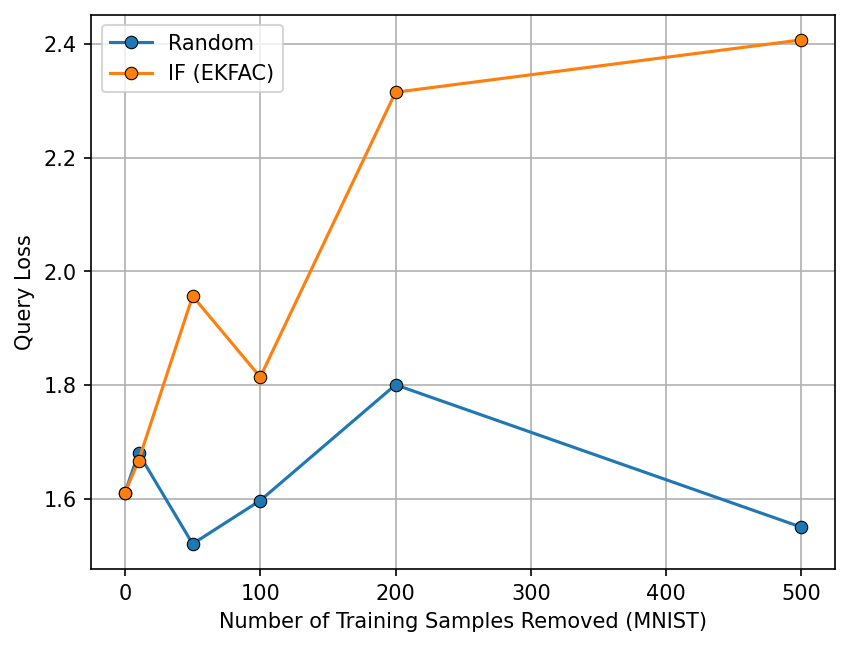

In [168]:
plt.plot([0] + topk_lst, [base_loss] + random_removed_loss_lst, "o-", label="Random")
#plt.plot([0] + topk_lst, [base_loss] + id_removed_loss_lst, "o-", label="TracIn (Identity)")
plt.plot([0] + topk_lst, [base_loss] + if_removed_loss_lst, "o-", label="IF (EKFAC)")
plt.grid()
plt.legend()
plt.ylabel("Query Loss")
plt.xlabel("Number of Training Samples Removed (MNIST)")

#### random baseline

In [166]:
random_indices = list(range(len(train_dataset)))
shuffle(random_indices)
random_removed_loss_lst = []

for topk in topk_lst:
    keep_indices = random_indices[topk:]
    
    new_loss = 0
    for _ in range(num_iter):
        loss, corr = train_and_evaluate(modified_train_dataset=torch.utils.data.Subset(train_dataset, keep_indices), query_dataset=single_query_dataset)
        new_loss += loss
    new_loss /= num_iter
    random_removed_loss_lst.append(new_loss)

## TRAK Scores 